In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import pandas as pd
import statsmodels.api as sm
import matplotlib

In [2]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [3]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

In [4]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [5]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


In [6]:
furniture = furniture.set_index('Order Date')

In [7]:
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,879.939


In [8]:
y = furniture['Sales'].resample('MS').mean()

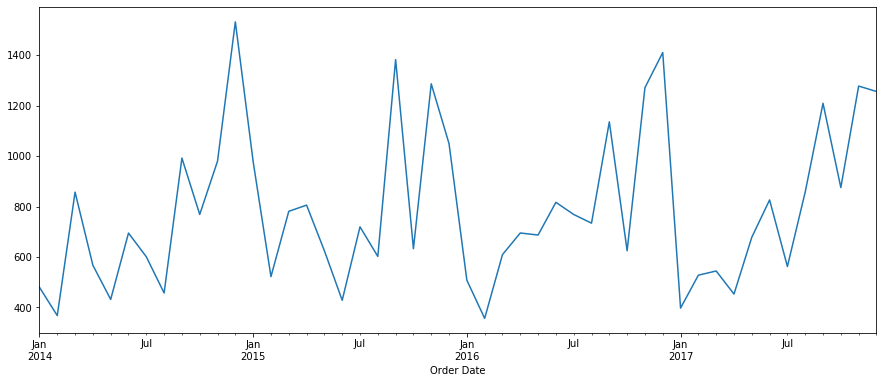

In [9]:
y.plot(figsize=(15, 6))
plt.show()

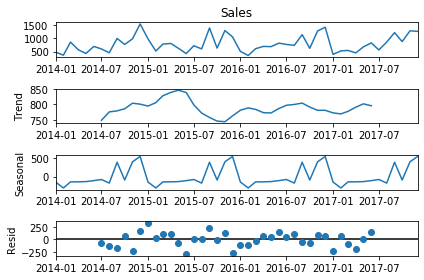

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

nresult = seasonal_decompose(y)

nresult.plot()
plt.show()

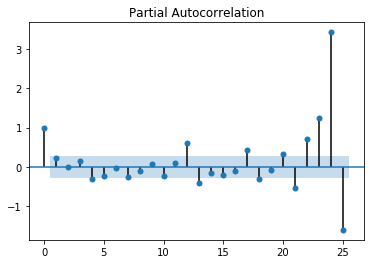

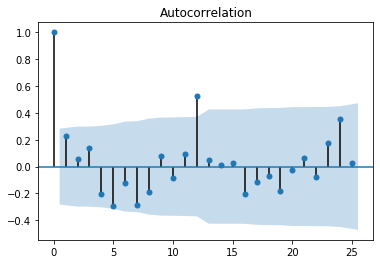

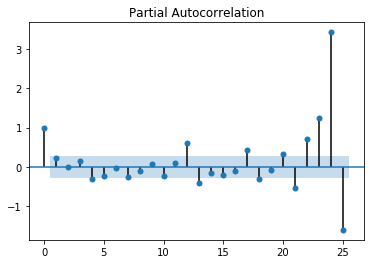

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y, lags=25)
plot_pacf(y, lags=25)

In [28]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(y)
print(result[1])

# This means its stationary, d=0

9.168756655665896e-06


In [13]:
y[:'2016']

Order Date
2014-01-01     480.194231
2014-02-01     367.931600
2014-03-01     857.291529
2014-04-01     567.488357
2014-05-01     432.049188
2014-06-01     695.059242
2014-07-01     601.169500
2014-08-01     457.521656
2014-09-01     992.353367
2014-10-01     769.015437
2014-11-01     980.221486
2014-12-01    1532.298325
2015-01-01     978.328467
2015-02-01     522.395667
2015-03-01     781.236437
2015-04-01     805.822962
2015-05-01     624.996700
2015-06-01     428.565500
2015-07-01     719.706316
2015-08-01     602.412012
2015-09-01    1382.790684
2015-10-01     632.980184
2015-11-01    1286.701354
2015-12-01    1049.355418
2016-01-01     508.182867
2016-02-01     356.868273
2016-03-01     609.575810
2016-04-01     695.373158
2016-05-01     687.265227
2016-06-01     816.910750
2016-07-01     768.736412
2016-08-01     734.307782
2016-09-01    1135.953371
2016-10-01     624.872474
2016-11-01    1271.345152
2016-12-01    1410.719808
Freq: MS, Name: Sales, dtype: float64

In [48]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(y[:'2016'],order=(3, 0, 1))
results = model.fit()
print(results.summary())

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                   36
Model:                     ARMA(3, 1)   Log Likelihood                -255.674
Method:                       css-mle   S.D. of innovations            293.367
Date:                Wed, 15 Jul 2020   AIC                            523.348
Time:                        14:32:39   BIC                            532.849
Sample:                    01-01-2014   HQIC                           526.664
                         - 12-01-2016                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         787.1200     74.893     10.510      0.000     640.333     933.907
ar.L1.Sales    -0.0809      0.594     -0.136      0.892      -1.246       1.084
ar.L2.Sales     0.1074      0.225      0.478    

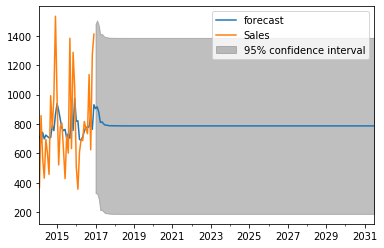

In [49]:
results.plot_predict(1,210)
plt.show()

In [50]:
pred = results.predict(start='2017-01',end='2017-12')

In [51]:
pred

2017-01-01    904.426740
2017-02-01    916.814496
2017-03-01    882.208683
2017-04-01    810.848919
2017-05-01    814.752298
2017-06-01    801.611312
2017-07-01    792.453792
2017-08-01    792.365145
2017-09-01    789.429263
2017-10-01    788.291855
2017-11-01    788.055297
2017-12-01    787.514507
Freq: MS, dtype: float64

In [52]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

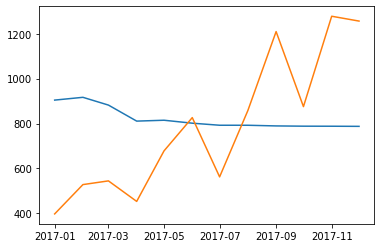

In [53]:
plt.plot(pred)
plt.plot(y['2017':])

In [35]:
result = adfuller(y['2017':])
print(result[1])
#Why 1.0, previously checked?

1.0


### Since arima doesnt support seasonality we try sarima

In [87]:
mod = sm.tsa.statespace.SARIMAX(y[:'2016'],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   36
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -63.978
Date:                             Wed, 15 Jul 2020   AIC                            135.955
Time:                                     15:40:23   BIC                            137.165
Sample:                                 01-01-2014   HQIC                           134.627
                                      - 12-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5935      0.893      0.665      0.506      -1.157       2.344
ma.L1         -1.0003    26

In [88]:
pred = results.predict(start='2017-01',end='2017-12')

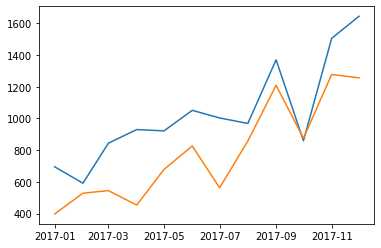

In [86]:
plt.plot(pred)
plt.plot(y['2017':])

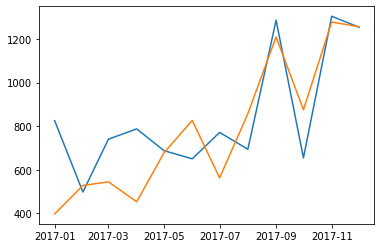

In [89]:
plt.plot(pred)
plt.plot(y['2017':])